In [3]:
import os
import numpy as np
import random
from itertools import combinations

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

np.random.seed(7)
np.set_printoptions(precision=4)

datasetDir = '/home/sang/dataset/TUG/arrangedData_LabelSave' ; print(" Prev workaing path [root]", os.getcwd())  
os.chdir(datasetDir) ; print(" Current workaing path [dataset] ", os.getcwd())  # -- Dataset 있는 곳으로 경로 변경 

 Prev workaing path [root] /home/sang/dataset/TUG/arrangedData_LabelSave
 Current workaing path [dataset]  /home/sang/dataset/TUG/arrangedData_LabelSave


/home/sang/miniconda3/envs/tug/lib/python3.8/site-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [2]:
a = [1,2,3,4,5]
c = list(combinations(a, 3))
print("[K-fold] ", c )

[K-fold]  [(1, 2, 3), (1, 2, 4), (1, 2, 5), (1, 3, 4), (1, 3, 5), (1, 4, 5), (2, 3, 4), (2, 3, 5), (2, 4, 5), (3, 4, 5)]


In [3]:
def trainData_split(datasetDir,ratio = 0.7, displayResult= True, shuffle =False,  train_Kfold = False):      
    expDates = next(os.walk(datasetDir))[1]  # ['2020_11_03_(result)', '2020_11_20_v1_(result)', '2020_11_20_v2_(result)']
    subjects = []
    for dateFolder in expDates:
        dateDir = os.path.join(datasetDir, dateFolder) 
        dataTypeDir = os.path.join(dateDir, "Labeled_CSV")
        date_subjects = (next(os.walk(dataTypeDir))[1])
        subjects.append(date_subjects)
    print(subjects)

    # 2D -> 1D [[sub1, sub2], [sub3, sub4]] -> [sub1, sub2, sub3, sub4]
    total_subjects = []
    for i in subjects:
        total_subjects+=i
    if shuffle:
        random.shuffle(total_subjects)
        
    trainIdx = np.round((len(total_subjects)*ratio),0).astype(int)
    train_subjects = total_subjects[:trainIdx]
    test_subjects = total_subjects[trainIdx:]
    if displayResult:
        print("----> Train subjects: {0} 명, {1} \n----> Test subjects: {2} 명, {3}".format(len(train_subjects), train_subjects, len(test_subjects), test_subjects ))
        
    if train_Kfold:
        train_subFold = list(combinations(train_subjects, 3))
        print("[K-fold] ", train_subFold )
        return train_subFold, test_subjectsS
    else:
        return train_subjects, test_subjects

train_subjects, test_subjects = trainData_split(datasetDir,ratio = 0.7,shuffle = False, train_Kfold = False)    
train_subjects =  ['NHJ_60',  'yjh', 'kyh', 'pss' ,'cyj_tug', 'cbd', 'cyj2', 'bys', 'jdh', 'jek', 'kch', 'kw', 'nhs', 'rjh'] 
normal_subjects = ['lhs', 'pjh', 'cbd_tug', 'bys_tug','cyj','JDW_tug_fixed']
patients_subjects = ['JDW_tug_fixed']


test_subjects = patients_subjects

[['JDW_tug'], ['JDW_tug_fixed'], ['cbd_tug', 'bys_tug', 'cyj_tug'], ['cbd', 'cyj2', 'cyj', 'bys', 'jdh', 'jek', 'kch'], ['kw', 'nhs', 'rjh', 'lhs', 'pjh', 'yjh', 'NHJ_60', 'kyh', 'pss']]
----> Train subjects: 15 명, ['JDW_tug', 'JDW_tug_fixed', 'cbd_tug', 'bys_tug', 'cyj_tug', 'cbd', 'cyj2', 'cyj', 'bys', 'jdh', 'jek', 'kch', 'kw', 'nhs', 'rjh'] 
----> Test subjects: 6 명, ['lhs', 'pjh', 'yjh', 'NHJ_60', 'kyh', 'pss']


In [4]:
numFeature = 3
numActions = 5

def getPelvisData(csvFile):
    rawData = np.loadtxt(csvFile, delimiter=",")
    timestamp = rawData[:,0]
    pelvis_x = rawData[:,1]
    pelvis_y = rawData[:,2]
    pelvis_z = rawData[:,3]
    actionList = rawData[:,4:9]
    return timestamp, pelvis_x, pelvis_y, pelvis_z, actionList

def create_dataset(datasetDir, train_subjects, test_subjects, displayResult = True):
    train_x = np.zeros((0, numFeature))
    train_y = np.zeros((0, numActions))
    test_x = np.zeros((0, numFeature))
    test_y = np.zeros((0, numActions))    
    
#     trainSet = None
#     testSet = None

    expDates = next(os.walk(datasetDir))[1]  # ['2020_11_03_(result)', '2020_11_20_v1_(result)', '2020_11_20_v2_(result)']
    for dateFolder in expDates:
        dateDir = os.path.join(datasetDir, dateFolder) 
        dataTypeDir = os.path.join(dateDir, "Labeled_CSV")
        subjects = next(os.walk(dataTypeDir))[1]
        
        for subjectName in subjects:
            subjectDir = os.path.join(dataTypeDir, subjectName)
            for csvFileName  in next(os.walk(subjectDir))[2]:  
                csvFile = os.path.join(subjectDir, csvFileName) 
                timestamp, pelvis_x, pelvis_y, pelvis_z, actionList = getPelvisData(csvFile) 

                    # -------- bind 
    #                 pelvisData = np.array([timestamp, pelvis_x, pelvis_y, pelvis_z]).T   # (frameNum, 4)
                pelvisData = np.array([pelvis_x, pelvis_y, pelvis_z]).T              # (frameNum, 3) 
                actionData = np.array(actionList)                                    # (frameNum, 5)
                dataset = tf.data.Dataset.from_tensor_slices( (pelvisData.astype('float32'), actionData.astype('float32')) )
                
                if subjectName in train_subjects:
                    train_x = np.append(train_x, pelvisData, axis = 0 )
                    train_y = np.append(train_y, actionData, axis = 0 )
#                     if trainSet == None:
#                         trainSet = dataset
#                     else:
#                         trainSet = trainSet.concatenate(dataset)
              
                elif subjectName in test_subjects:                   
                    test_x = np.append(test_x, pelvisData, axis = 0 )
                    test_y = np.append(test_y, actionData, axis = 0 )
#                     if testSet == None:
#                         testSet = dataset
#                     else:
#                         testSet = testSet.concatenate(dataset)

    if displayResult:
        print(" Train Shape X , Y: {0} , {1} \n Test Shape X , Y: {2} , {3}".format(train_x.shape, train_y.shape, test_x.shape, test_y.shape))
    return train_x, train_y, test_x, test_y
                              
train_x, train_y, test_x, test_y = create_dataset(datasetDir, train_subjects, test_subjects, displayResult = True)


 Train Shape X , Y: (55982, 3) , (55982, 5) 
 Test Shape X , Y: (1033, 3) , (1033, 5)


In [5]:
def time_series_to_section(data_x, data_y, numActions, sliding_window_size, step_size_of_sliding_window, standardize=False, **options):
    data = data_x  # sensor data
    act_labels = data_y  # action labels
    mean = 0
    std = 1
    
    trainSet = None
    testSet = None
    if standardize:
            # As usual, normalize test dataset by training dataset's parameters
        if options:
            mean = options.get("mean")
            std = options.get("std")
                # \n test mean: {0}, std: {1}\n\n".format(mean,std))
            print("Test Data has been standardized:")
        else:
                # csv 한 줄의 mean ..이걸 모든 sensor data들에 대해 수행
            mean = data.mean(axis=0)
            std = data.std(axis=0)
            print("Training Data has been standardized:\n the mean is = ", str(mean.mean()), " ; and the std is = ", str(std.mean()))
            # mean removal and variance scaling
        data -= mean
        data /= std
    else:
        print("----> Without Standardization.....")

        # We want the Rows of matrices show each Feature and the Columns show time points.
        # before transepose,,(145687, 12) -->  After (12, 145687)
    data = data.T

    size_features = data.shape[0]  # 4
    size_data = data.shape[1]

    number_of_secs = round( ((size_data - sliding_window_size)/step_size_of_sliding_window) )

        # Create a 3D matrix for Storing Snapshots
    secs_data = np.zeros((number_of_secs, size_features, sliding_window_size))
    act_secs_labels = np.zeros((number_of_secs, numActions))
    print("number of sections: ", number_of_secs, "size of data", size_data )
    k = 0
    for i in range(0, (size_data) - sliding_window_size, step_size_of_sliding_window):
        j = i // step_size_of_sliding_window # 0, 3, 6, 12
        if(j >= number_of_secs):
            break

        if(not (act_labels[i] == act_labels[i+sliding_window_size-1]).all()):
            continue

        secs_data[k] = data[0:size_features, i:i+sliding_window_size]
        act_secs_labels[k] = act_labels[i].astype(int)
        k = k+1
    secs_data = secs_data[0:k]    
    act_secs_labels = act_secs_labels[0:k]

    return secs_data, act_secs_labels, mean, std

In [6]:
sliding_window_size = 15 # 30.. 1sec.. 50 Equals to 1 sec for MotionSense Dataset (it is on 50Hz samplig rate)
step_size_of_sliding_window = 3 #10 
print("--> Sectioning Training and Test datasets: shape of each section will be: (", numFeature, "x", sliding_window_size, ")")

train_x_secs, train_y_secs, train_mean, train_std = time_series_to_section(train_x.copy(), train_y.copy(), numActions, sliding_window_size,step_size_of_sliding_window, standardize = True)

test_x_secs, test_y_secs, test_mean, test_std = time_series_to_section(test_x.copy(), test_y.copy(), numActions, sliding_window_size, step_size_of_sliding_window, standardize = True, mean = train_mean, std = train_std)

print("\n\n---> Training X Section: {0} , Training Label Section: {1} \n---> Test X Sections: {2} , Test Label Sections: {3}".format(train_x_secs.shape, train_y_secs.shape, test_x_secs.shape, test_y_secs.shape))

--> Sectioning Training and Test datasets: shape of each section will be: ( 3 x 15 )
Training Data has been standardized:
 the mean is =  1643.6503128823158  ; and the std is =  610.8410907503521
number of sections:  18656 size of data 55982
Test Data has been standardized:
number of sections:  339 size of data 1033


---> Training X Section: (14743, 3, 15) , Training Label Section: (14743, 5) 
---> Test X Sections: (285, 3, 15) , Test Label Sections: (285, 5)


In [7]:
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.layers import Conv2D , MaxPooling2D, Dropout

## Here we add an extra dimension to the datasets just to be ready for using with Convolution2D
train_x_block = np.expand_dims(train_x_secs, axis=3)
test_x_block = np.expand_dims(test_x_secs, axis=3)
print("---> Training Section: {0} , Test Sections: {1}".format(train_x_block.shape, test_x_block.shape))

---> Training Section: (14743, 3, 15, 1) , Test Sections: (285, 3, 15, 1)


In [8]:
num_train, height, width, channel = train_x_block.shape  #   (13298, 4, 15, 1) =  (number_of_secs , size_features , sliding_window_size, 1)
metrics = ['acc']

## MTCNN
drop_prob_1 = 0.2 
drop_prob_2 = 0.4 


## Action model 
action_layer_dim = numActions # 4  # dws, ups, wlk, jog # , sit,  std 
action_activation_func = 'softmax'
action_loss_func = 'categorical_crossentropy'


def activityModel():
    input_layer = Input(shape = (height, width, 1) ) # (4, 15, 1) = (feature, sliding_window, 1)

    conv_0 = Conv2D(15, kernel_size=(1, 5), strides=(1, 1), padding='valid',  activation='relu') (input_layer) #5
    conv_1 = Conv2D(15, kernel_size=(1, 5), strides=(1, 1), padding='same', activation='relu') (conv_0)
    dense_1 = Dense(50, activation='relu') (conv_1)
    pool_1 = MaxPooling2D(pool_size=(1,2)) (dense_1)
    drop_1 = Dropout(drop_prob_1)(pool_1)


    conv_2 = Conv2D(11, kernel_size=(1, 3), strides=(1, 1), padding='valid',  activation='relu') (drop_1)# 5
    dense_2 = Dense(40, activation='relu') (conv_2)
    pool_2 = MaxPooling2D(pool_size=(1, 3)) (dense_2)  
    drop_2 = Dropout(drop_prob_1) (pool_2)

    conv_3 = Conv2D(10, kernel_size=(1, 3), strides=(1, 1), padding='same',  activation='relu') (drop_2)
    drop_3 = Dropout(drop_prob_1)(conv_3)

    flat = Flatten() (drop_3)
    hidden = Dense(400, activation = 'relu') (flat)
    drop_4 = Dropout(drop_prob_2)(hidden)

    action_out = Dense(action_layer_dim, activation = action_activation_func, name = 'ACTION') (drop_4)
    
    # --------- Model input/ Output Definition
    activity_model = Model(inputs=input_layer, outputs = action_out)
    activity_model.summary()

    activity_model.compile(loss=action_loss_func, optimizer=keras.optimizers.Adam(0.001), metrics=metrics)

    return activity_model

In [9]:
## Training Phase
batch_size = 64
num_of_epochs = 30 # 35
verbosity = 1

# Model Training 
model = activityModel()
history = model.fit(train_x_block, train_y_secs,                
              batch_size = batch_size,
              epochs = num_of_epochs,
              verbose = verbosity) 

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3, 15, 1)]        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 3, 11, 15)         90        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 11, 15)         1140      
_________________________________________________________________
dense (Dense)                (None, 3, 11, 50)         800       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 5, 50)          0         
_________________________________________________________________
dropout (Dropout)            (None, 3, 5, 50)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 11)          1661  

In [10]:
#------------- Evaluation 
results_1 = model.evaluate(test_x_block, test_y_secs, verbose = verbosity)
print("--> Evaluation on Test Dataset:")
print("**** Accuracy for Activity Recognition task is: ", results_1)


# ----------------- 
y_predict = model.predict(test_x_block) # (6161, 5)  
y_pred_index = y_predict.argmax(axis=1) # print(y_pred_index) 
y_true_idx = np.argmax(test_y_secs, axis=1) # print(y_true_idx)

correct = np.nonzero(y_true_idx == y_pred_index) # print(correct, len(correct[0]))
incorrect = np.nonzero(y_true_idx != y_pred_index) # print(incorrect, len(incorrect[0]))

valid_num = len(correct[0]) + len(incorrect[0])
tot_num = len(y_true_idx)
# print("[must same] # of real data: ", tot_num, "==  # of pred data: ", valid_num)
percent_correct = len(correct[0]) /tot_num
percent_incorrect = len(incorrect[0])/tot_num
print(" correct: ", percent_correct," [%]", ",  incorrect: ", percent_incorrect," [%]")

9/9 [==============================] - 0s 4ms/step - loss: 1.9824 - acc: 0.6912
--> Evaluation on Test Dataset:
**** Accuracy for Activity Recognition task is:  [1.982426404953003, 0.6912280917167664]
 correct:  0.6912280701754386  [%] ,  incorrect:  0.3087719298245614  [%]


In [11]:
print(y_true_idx)

[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0]


In [11]:
# def session_to_data(origin_x, origin_y, block_x, block_y, mode = 'test'):     # (# of train/test , # of features, slidingWindow, 1) (# of train/test, # of actions)
#     sliding_window_size = 15
#     step_size_of_sliding_window = 3
#     print(block_x.shape, block_y.shape)
#     print(block_x.reshape(-1,3,sliding_window_size).shape)  # (# of train/test , # of features, slidingWindow,) (# of train/test, # of actions)

# #     23224
#     data =[]
#     section = block_x.shape[0]
#     print(secsSize )
#     for i in rnage(15):
#         for j in range(3):
#             section 
        
        

        
            
# #     print(np.array(data))
# #     act_secs_labels = np.zeros((number_of_secs, 5))
# #     print("number of sections: ", number_of_secs, "size of data", size_data )
# #     k = 0
# #     for i in range(0, (size_data) - sliding_window_size, step_size_of_sliding_window):
# #         j = i // step_size_of_sliding_window # 0, 3, 6, 12
# #         if(j >= number_of_secs):
# #             break

# #         if(not (act_labels[i] == act_labels[i+sliding_window_size-1]).all()):
# #             continue

# #         secs_data[k] = data[0:size_features, i:i+sliding_window_size]
# #         act_secs_labels[k] = act_labels[i].astype(int)
# #         k = k+1
# #     secs_data = secs_data[0:k]    
# #     act_secs_labels = act_secs_labels[0:k]
# session_to_data(test_x, test_y, test_x_block, y_predict)

(6072, 3, 15, 1) (6072, 5)
(6072, 3, 15)
6072


In [14]:
# pelvis_y = 2
# # for dataIdx in range(tot_num):
# #     print(test_x_secs[:,2,:])
    
# fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(20, 10))
# ax[0].plot(test_x_secs[:,0,0], test_x_secs[:,2,0], 'g--', lw=0.1, label='sitting')
# ax[1].plot(x, y_predict[:,1], 'b*', lw=0.1, label='sitStand')
# ax[2].plot(x, y_predict[:,2], 'r*', lw=0.1, label='walking')
# ax[3].plot(x, y_predict[:,3], 'g*', lw=0.1, label='Turning')
# ax[4].plot(x, y_predict[:,4], 'b*', lw=0.1, label='standSit')
# plt.legend()
# plt.show()

y_predict = model.predict(test_x)
print(y_predict.shape) # (6161, 5)  , sliding window size 
print(y_predict.argmax(axis=1)) 
print(test_y_secs[y_predict.argmax(axis=1)])

x = np.arange(len(y_predict))

fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(20, 10))
ax[0].plot(x, y_predict[:,0], 'r--', lw=1, label='sitting')
ax[1].plot(x, y_predict[:,1], 'b--', lw=1, label='sitStand')
ax[2].plot(x, y_predict[:,2], 'g--', lw=1, label='walking')
ax[3].plot(x, y_predict[:,3], 'r--', lw=1, label='Turning')
ax[4].plot(x, y_predict[:,4], 'b--', lw=1, label='standSit')
plt.legend()
plt.show()


ValueError: in user code:

    /home/sang/miniconda3/envs/tug/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1147 predict_function  *
        outputs = self.distribute_strategy.run(
    /home/sang/miniconda3/envs/tug/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/sang/miniconda3/envs/tug/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/sang/miniconda3/envs/tug/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/sang/miniconda3/envs/tug/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1122 predict_step  **
        return self(x, training=False)
    /home/sang/miniconda3/envs/tug/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /home/sang/miniconda3/envs/tug/lib/python3.8/site-packages/tensorflow/python/keras/engine/network.py:717 call
        return self._run_internal_graph(
    /home/sang/miniconda3/envs/tug/lib/python3.8/site-packages/tensorflow/python/keras/engine/network.py:888 _run_internal_graph
        output_tensors = layer(computed_tensors, **kwargs)
    /home/sang/miniconda3/envs/tug/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:885 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /home/sang/miniconda3/envs/tug/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:176 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer conv2d is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: [None, 3]


correct:  (array([], dtype=int64),)


<ipython-input-13-1f83da0deaf2>:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  correct = np.nonzero(y_pred == y_test)
<ipython-input-13-1f83da0deaf2>:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  incorrect = np.nonzero(y_pred != y_test)


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

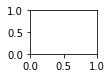

In [13]:
y_pred = test_y[y_predict.argmax(axis=1)]
y_test =np.argmax(test_y,axis=1)

correct = np.nonzero(y_pred == y_test)
incorrect = np.nonzero(y_pred != y_test)
print("correct: ", correct)

### Check the correctly-predicted samples
plt.figure(1)
for i, cor in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.subplots_adjust(hspace=1.0,wspace=1.0)
    plt.plot(test_x.iloc[cor,:])
    plt.title("Predicted:{}\nTrue:{}".format(activity_types[y_pred[cor]-1], 
                                              activity_types[y_test[cor]-1]))
    plt.xticks([]) # turn off x labels
    plt.yticks([])  # turn off y labels
    #plt.tight_layout()
plt.show()
### Check the incorrectly-predicted samples
plt.figure(2)
for i, cor in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.subplots_adjust(hspace=1.0,wspace=1.0)
    plt.plot(test_x.iloc[cor,:])
    plt.title("Predicted:{}\nTrue:{}".format(activity_types[y_pred[cor]-1], 
                                              activity_types[y_test[cor]-1]))
    plt.xticks([]) # turn off x labels
    plt.yticks([])  # turn off y labels
    #plt.tight_layout()
plt.show()

In [ ]:
### Confusion matrix (predictive performance on different classes)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    function provided by sklearn example
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=activity_types,
                      title='Confusion matrix, without normalization')